# POS Tagger Trained on the UD Treebank

Adapted from https://github.com/soutsios/pos_tagger_mlp/blob/master/pos_tagger_mlp.ipynb 

In [1]:
import pyconll, nltk, datetime, warnings
import numpy as np
from scipy.sparse import vstack
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
from numpy.random import seed

# Plot Functions

These functions are useful to visualize the training dynamics of the learning algorithm and the confusion matrix of the trained models.

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [3]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

# Load Dataset

In [4]:
UD_ENGLISH_TRAIN = '../UD_English-EWT/en_ewt-ud-train.conllu'
UD_ENGLISH_DEV = '../UD_English-EWT/en_ewt-ud-dev.conllu'
UD_ENGLISH_TEST = '../UD_English-EWT/en_ewt-ud-test.conllu'

# Preprocessing

In [5]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    original_sentences=[]
    t=0
    for sentence in data:
        original_sentences.append(sentence.text)
        tagged_sentence=[]
        for token in sentence:
            if token.upos:
                t+=1
                tagged_sentence.append((token.form if token.form else '*None*', token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences, original_sentences

Load train, development and test set in the appropriate tagged format, tuple (word, pos-tag)

In [6]:
train_sentences, train_original = read_conllu(UD_ENGLISH_TRAIN)
val_sentences, val_original = read_conllu(UD_ENGLISH_DEV)
test_sentences, test_original = read_conllu(UD_ENGLISH_TEST)

Print statistics

In [8]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))

Tagged sentences in train set:  12544
Tagged words in train set: 204616
Tagged sentences in dev set:  2001
Tagged words in dev set: 25153
Tagged sentences in test set:  2077
Tagged words in test set: 25096


In [9]:
print(train_sentences[0])

[('Al', 'PROPN'), ('-', 'PUNCT'), ('Zaman', 'PROPN'), (':', 'PUNCT'), ('American', 'ADJ'), ('forces', 'NOUN'), ('killed', 'VERB'), ('Shaikh', 'PROPN'), ('Abdullah', 'PROPN'), ('al', 'PROPN'), ('-', 'PUNCT'), ('Ani', 'PROPN'), (',', 'PUNCT'), ('the', 'DET'), ('preacher', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('mosque', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('town', 'NOUN'), ('of', 'ADP'), ('Qaim', 'PROPN'), (',', 'PUNCT'), ('near', 'ADP'), ('the', 'DET'), ('Syrian', 'ADJ'), ('border', 'NOUN'), ('.', 'PUNCT')]


In [10]:
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]

def id2word(sentences):
    wordlist = [item for sublist in text_sequence(sentences) for item in sublist]
    id2word = {k:v for k,v in enumerate(wordlist)}
    return id2word

def untag(tagged_sentence):
    return [w for w, _ in tagged_sentence]

def untag_pos(tagged_sentence):
    return [t for _, t in tagged_sentence]

def build_vocab(sentences):
    vocab =set()
    for sentence in sentences:
        for word in untag(sentence):
            vocab.add(word)
    return sorted(list(vocab))

An important observation: how many terms are in validation set and not found in train set? (This estimates the Out-of-vocabulary rate.)

In [11]:
list_1 = build_vocab(train_sentences)
list_2 = build_vocab(val_sentences)
diff_list = [item for item in list_2 if item not in list_1]
print('Number of terms not found in train set:',len(diff_list))

Number of terms not found in train set: 1661


# Feature Engineering

We use the "classical" machine learning approach: we will train a token classifier model. The classifier gets as input a feature vector describing each token in the sentence. We decide a priori which features are informative to make the tagging decision. In this case, we use a combination of "word shape" features which approximate morphological knowledge. We naturally also include lexical information (the token form itself), and some form of "syntactic knowledge" by adding reference to the previous and next word in each token feature vector.

In [12]:
def features_basic(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'nb_terms': len(sentence),        
        'word': sentence[index],
        'word_lower': sentence[index].lower(),
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'i-1_prefix-3': '' if index == 0 else sentence[index-1][:3],        
        'i-1_suffix-3': '' if index == 0 else sentence[index-1][-3:],        
        'i+1_prefix-3': '' if index == len(sentence) - 1 else sentence[index+1][:3],        
        'i+1_suffix-3': '' if index == len(sentence) - 1 else sentence[index+1][-3:],        
        'prev_word': '' if index == 0 else sentence[index - 1].lower(),
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1].lower(),
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:],
    }

In the scikit-learn model, we model a dataset as a pair of two data structures:
* The list of feature dictionaries X (one feature dictionary for each token)
* The list of predicted label y (one tag for each token)

In [13]:
def transform_to_dataset(tagged_sentences):
    X, y = [], []
    for doc_index, tagged in enumerate(tagged_sentences):
        for index in range(len(tagged)):
            X.append([features_basic(untag(tagged), index)])
            y.append(tagged[index][1])
    return X, y

Given a sentence represented as a list of tokens, return the list of feature dictionaries using our feature encoding method:

In [14]:
def transform_test_sentence(sentence):
    X = []
    for index in range(len(sentence)):
            X.append([features_basic(sentence, index)])
    return X

## Test untag()

We use untag() to extract raw sentences from the annotated CoNLL dataset. This way we can reproduce a sentence without tags, submit it to the tagger and compare predictions to the gold tags that are provided in the dataset.

In [15]:
untag(test_sentences[1])

['What',
 'if',
 'Google',
 'expanded',
 'on',
 'its',
 'search',
 '-',
 'engine',
 '(',
 'and',
 'now',
 'e-mail',
 ')',
 'wares',
 'into',
 'a',
 'full',
 '-',
 'fledged',
 'operating',
 'system',
 '?']

# Dataset Transformation

Before we can apply a generic machine learning algorithm (such as Logistic Regression), we need to encode the dataset into a vectorized format.

We proceed in two steps: feature engineering and vectorization.

For each token, we create a dictionary of features that depend on the sentence from which the token is extracted. 
These features include the word itself, the word before and the word after, letter suffixes and prefixes, etc.

In the scikit-learn approach, before we can use a generic machine learning algorithm, we must then "vectorize" the feature dictionaries into vector encodings.
For example, lexical features are encoded into one-hot vectors whose dimension is the size of the vocabulary.
Note the difference between the method `fit_transform` of the vectorizer, which "learns" how to vectorize features, and `transform` which applies a learned vectorizer to feature dictionaries.  We use `fit_transform` on the training data, and `transform` on the other sections (validation and test).

These vector representations are what is passed to the machine learning algorithm.

In [16]:
def vectorize(train, val, test):

    print('Feature encoding method')
    print('Vectorizing Dataset...')
    print('Vectorizing train...')
    X_train, y_train = transform_to_dataset(train)
    v = DictVectorizer(sparse=True) 
    X_train = v.fit_transform([x[0] for x in X_train])
    
    print('Vectorizing validation...')
    X_val, y_val = transform_to_dataset(val)
    X_val = v.transform([x[0] for x in X_val])        
    
    print('Vectorizing test...')
    X_test, y_test = transform_to_dataset(test)
    X_test = v.transform([x[0] for x in X_test])
    
    print('Dataset vectorized.')
    print('Train shape:', X_train.shape)
    print('Validation shape:', X_val.shape)
    print('Test shape:', X_test.shape)
    
    # Compress sparse matrices
    X_train = X_train 
    X_val = X_val 
    X_test = X_test
    return X_train, y_train, X_val, y_val, X_test, y_test, v
    

# Baseline Tagger

Before we train a "real" machine learning algorithm using scikit-learn, we will repeat the very simple statistical method we discussed in class.
We train and evaluate the Baseline Unigram tagger to compare performance with the tagger we will train next.

In [17]:
default_tagger = nltk.DefaultTagger('NOUN')
unigram_tagger = nltk.UnigramTagger(train_sentences+val_sentences, backoff=default_tagger)

In [18]:
y_train = [item for sublist in tag_sequence(train_sentences+val_sentences) for item in sublist]
y_test = [item for sublist in tag_sequence(test_sentences) for item in sublist]
classes = sorted(list(set(y_train)))

In [19]:
def tag_list(tagged_sents):
    return [tag for sent in tagged_sents for (word, tag) in sent]
def apply_tagger(tagger, corpus):
    return [tagger.tag(nltk.tag.untag(sent)) for sent in corpus]

In [20]:
y_pred = tag_list(apply_tagger(unigram_tagger, test_sentences))
print("Accuracy: {0:.4f}".format(unigram_tagger.accuracy(test_sentences)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, zero_division=1, average='macro')))

Accuracy: 0.8671
f1-macro score: 0.7965


In [21]:
print(classification_report(y_test, y_pred, zero_division=1, digits=4))

              precision    recall  f1-score   support

         ADJ     0.9158    0.8367    0.8745      1794
         ADP     0.8697    0.8813    0.8755      2030
         ADV     0.9341    0.8030    0.8636      1183
         AUX     0.9233    0.8970    0.9099      1543
       CCONJ     0.9892    0.9973    0.9932       736
         DET     0.9612    0.9678    0.9645      1896
        INTJ     0.9655    0.6942    0.8077       121
        NOUN     0.6879    0.9331    0.7920      4123
         NUM     0.9146    0.6125    0.7337       542
        PART     0.6959    0.9769    0.8128       649
        PRON     0.9665    0.9321    0.9490      2166
       PROPN     0.9240    0.5443    0.6851      2076
       PUNCT     0.9941    0.9861    0.9901      3096
       SCONJ     0.6257    0.5964    0.6107       384
         SYM     0.8125    0.8349    0.8235       109
        VERB     0.8880    0.8243    0.8549      2606
           X     1.0000    0.0000    0.0000        42

    accuracy              

See what errors the Baseline tagger makes:

In [22]:
def check_tagger(tagged_sentence):
    note = ''
    for tup in list(zip(unigram_tagger.tag(untag(tagged_sentence)),untag_pos(tagged_sentence))):
        if tup[0][1]!=tup[1]: note='<<--- Error!'
        print(tup[0], tup[1], note)
        note=''

In [23]:
check_tagger(test_sentences[1])

('What', 'PRON') PRON 
('if', 'SCONJ') SCONJ 
('Google', 'PROPN') PROPN 
('expanded', 'VERB') VERB 
('on', 'ADP') ADP 
('its', 'PRON') PRON 
('search', 'NOUN') NOUN 
('-', 'PUNCT') PUNCT 
('engine', 'NOUN') NOUN 
('(', 'PUNCT') PUNCT 
('and', 'CCONJ') CCONJ 
('now', 'ADV') ADV 
('e-mail', 'NOUN') NOUN 
(')', 'PUNCT') PUNCT 
('wares', 'NOUN') NOUN 
('into', 'ADP') ADP 
('a', 'DET') DET 
('full', 'ADJ') ADV <<--- Error!
('-', 'PUNCT') PUNCT 
('fledged', 'NOUN') ADJ <<--- Error!
('operating', 'NOUN') NOUN 
('system', 'NOUN') NOUN 
('?', 'PUNCT') PUNCT 


It makes mistakes. Unsurprising given its simplistic approach and the small size of the training data.

In [24]:
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Baseline'

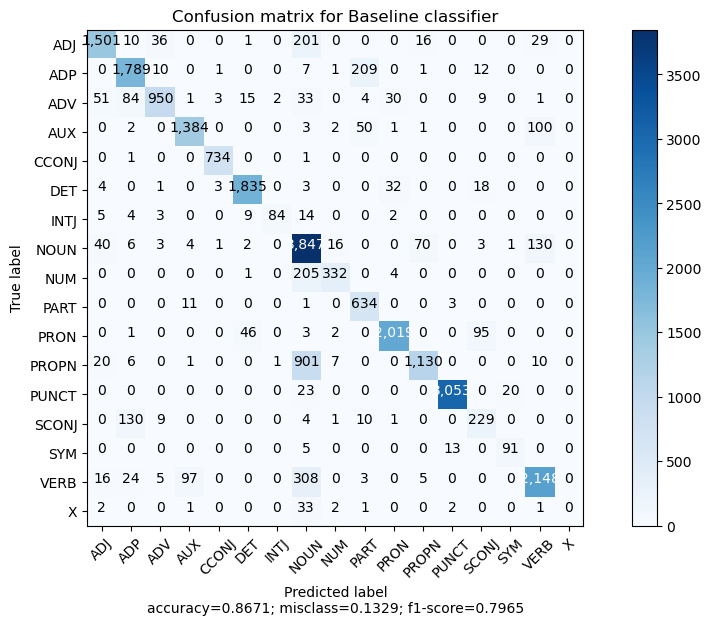

In [25]:
plot_confusion_matrix(f1_score(y_test, y_pred, average='macro'), cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

# Train a Logistic Regression Model

Let us move to a more serious machine learning model. We will train a Logistic Regression model using our feature extraction function based on our "expertise" in the domain.

We first transform the whole dataset from the CoNLL format into the scikit-learn vectorized encoding using our feature extraction method.

In [26]:
X_train, y_train, X_val, y_val, X_test, y_test, vec = vectorize(train_sentences, val_sentences, test_sentences)

Feature encoding method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (204616, 98724)
Validation shape: (25153, 98724)
Test shape: (25096, 98724)


## Hyper-parameter Tuning

The Logistic Regression algorithm uses a hyper-parameter called C.  We tune the value of this parameter by testing different values on a subset of the training data and observing the impact of the C parameter on selected metrics (accuracy and F1).

Because we will use cross-validation, we can use the full train set (train + validation)

In [27]:
X_train = vstack((X_train, X_val))
y_train = np.append(y_train, y_val, axis=0)

In [28]:
X_train.shape

(229769, 98724)

In [29]:
y_train.shape

(229769,)

In [30]:
def hyper_tuning(train, test, y_train, y_test, scores, estimator, parameters, cv):
    print("# Estimator:",estimator)
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)        
        clf = GridSearchCV(estimator, parameters, cv=cv, scoring='%s' % score)
        clf.fit(train, y_train)
        print("Best parameters set found on development set:")
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()
        print("Detailed classification report:")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        y_pred = clf.predict(test)
        print(classification_report(y_test, y_pred, digits=4))
        print('Accuracy: {0:0.4f}   f1-score: {1:0.4f} \n'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')))
    return clf

In [31]:
logregr = LogisticRegression(solver='liblinear', random_state=13)
# Cross validation strategy
skf = StratifiedKFold(n_splits=4)
# Scores could also be ['precision', 'recall', ....]
scores = ['accuracy', 'f1_macro']

params = [{'C': [0.1, 1, 2, 3, 4, 5, 10, 20, 50]}]
#logregr = hyper_tuning(X_train, X_test, y_train, y_test, scores, logregr, params, skf)
#You may want to comment previous line and comment-out next lines to see how hyper-tuning works and dont wait too much time...
skf = StratifiedKFold(n_splits=4)
logregr = hyper_tuning(X_train[:500], X_test[:50], y_train[:500], y_test[:50], scores, logregr, params, skf)

# Estimator: LogisticRegression(random_state=13, solver='liblinear')
# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'C': 20}

Grid scores on development set:
0.748 (+/-0.027) for {'C': 0.1}
0.828 (+/-0.046) for {'C': 1}
0.834 (+/-0.041) for {'C': 2}
0.836 (+/-0.035) for {'C': 3}
0.836 (+/-0.035) for {'C': 4}
0.838 (+/-0.029) for {'C': 5}
0.842 (+/-0.033) for {'C': 10}
0.846 (+/-0.035) for {'C': 20}
0.844 (+/-0.042) for {'C': 50}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

         ADJ     0.0000    0.0000    0.0000         2
         ADP     1.0000    0.6667    0.8000         6
         ADV     0.0000    0.0000    0.0000         3
         AUX     1.0000    1.0000    1.0000         1
       CCONJ     1.0000    0.5000    0.6667         2
         DET     0.6667    1.0000    0.8000         2
        NOUN  

## Training

We can now training using the best hyper-parameter selected above.  This takes a few minutes.

In [32]:
t_ini = datetime.datetime.now()
print('Training...')
clf = LogisticRegression(C=20, solver='liblinear', random_state=13)
clf.fit(X_train, y_train)
t_fin = datetime.datetime.now()
print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

Training...
Training completed in 314.07135 seconds


# Evaluation

In [33]:
y_pred = clf.predict(X_test)

In [34]:
print("Accuracy: {0:.4f}".format(clf.score(X_test, y_test)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

Accuracy: 0.9452
f1-macro score: 0.9026


## Classification Report

In [35]:
print(classification_report(y_test, clf.predict(X_test), digits=4))

              precision    recall  f1-score   support

         ADJ     0.9204    0.9019    0.9110      1794
         ADP     0.9329    0.9586    0.9456      2030
         ADV     0.9213    0.8901    0.9054      1183
         AUX     0.9787    0.9812    0.9799      1543
       CCONJ     0.9946    0.9932    0.9939       736
         DET     0.9905    0.9910    0.9908      1896
        INTJ     0.9712    0.8347    0.8978       121
        NOUN     0.9035    0.9202    0.9118      4123
         NUM     0.9743    0.9779    0.9761       542
        PART     0.9799    0.9769    0.9784       649
        PRON     0.9875    0.9871    0.9873      2166
       PROPN     0.8820    0.8608    0.8713      2076
       PUNCT     0.9913    0.9971    0.9942      3096
       SCONJ     0.8521    0.8099    0.8304       384
         SYM     0.8990    0.8165    0.8558       109
        VERB     0.9444    0.9578    0.9510      2606
           X     0.5000    0.2857    0.3636        42

    accuracy              

## Frequent Types of Mistakes

In [36]:
import collections
k=0
i2w = id2word(test_sentences)
error_counter = collections.Counter()
for i in range(X_test.shape[0]):
    correct_tag_id = y_test
    if y_pred[i]!=y_test[i]:
        k += 1
        word = i2w[i]
        error_counter[word] += 1
print('Accuracy: {0:.4f}'.format((len(i2w)-k)/len(i2w)))
print('Total errors/Total words: {}/{}\n'.format(k,len(i2w)))
print('Most common errors:',error_counter.most_common(20))

Accuracy: 0.9452
Total errors/Total words: 1376/25096

Most common errors: [('that', 25), ('as', 23), ('to', 23), ('like', 22), ('out', 18), ('for', 18), ('up', 18), ('/', 17), ('in', 17), ('on', 12), ('01-Feb-02', 11), ('much', 10), ('one', 9), ('-', 9), ('all', 8), ('so', 8), ('have', 7), ('be', 7), ('of', 6), ('has', 6)]


## Learning Curves

The following diagram illustrates the "training dynamics" of the LR model: how fast does it improve as it keeps training. Originally, the difference between the test dataset and the cross-validation (on part of the test data) is large; as training proceeds, the gap reduces. This diagram is important to verify we do not have a case of over-fitting - where the model does "very well" on training data and does not improve on test data.  

This computation takes a long time (as we keep training and evaluating multiple times to obtain the snapshots). It is not necessary to run the rest of the notebook so that you can safely skip it.

In [179]:
# plot_learning_curve(clf, 'Logistic Regression', X_train, y_train, ylim=(0.7, 1.01), cv=5)

## Confusion Matrix

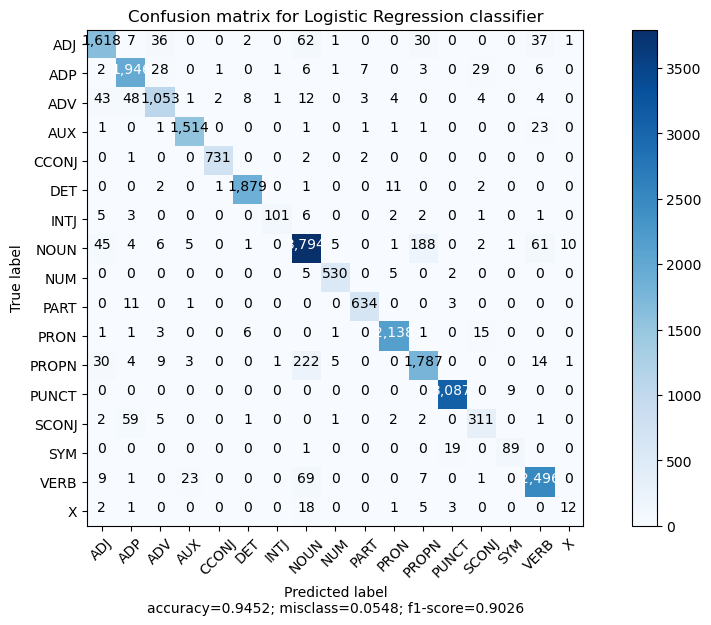

In [37]:
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Logistic Regression'
plot_confusion_matrix(f1, cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

## Tag an Unknown Sentence

Lets try our trained tagger on new sentences.  To tag a sentence given as a string, we must apply the following steps:
* Tokenize the string into a list of tokens
* Turn each token into a features dictionary (using the features used by our model)
* Turn the list of feature dictionaries into vectors (using scikit-learn vectorization method)
* Pass the resulting matrix (one row vector for each token) to the classifier.

In [38]:
# Need to download the nltk model for sentence tokenizer
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hadar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [39]:
tokens = nltk.word_tokenize('Word embeddings provide a dense representation of words and their relative meanings.')
print(tokens)

['Word', 'embeddings', 'provide', 'a', 'dense', 'representation', 'of', 'words', 'and', 'their', 'relative', 'meanings', '.']


In [40]:
X_features = transform_test_sentence(tokens)

In [41]:
X_features

[[{'nb_terms': 13,
   'word': 'Word',
   'word_lower': 'word',
   'is_first': True,
   'is_last': False,
   'is_capitalized': True,
   'is_all_caps': False,
   'is_all_lower': False,
   'prefix-1': 'W',
   'prefix-2': 'Wo',
   'prefix-3': 'Wor',
   'suffix-1': 'd',
   'suffix-2': 'rd',
   'suffix-3': 'ord',
   'i-1_prefix-3': '',
   'i-1_suffix-3': '',
   'i+1_prefix-3': 'emb',
   'i+1_suffix-3': 'ngs',
   'prev_word': '',
   'next_word': 'embeddings',
   'has_hyphen': False,
   'is_numeric': False,
   'capitals_inside': False}],
 [{'nb_terms': 13,
   'word': 'embeddings',
   'word_lower': 'embeddings',
   'is_first': False,
   'is_last': False,
   'is_capitalized': False,
   'is_all_caps': False,
   'is_all_lower': True,
   'prefix-1': 'e',
   'prefix-2': 'em',
   'prefix-3': 'emb',
   'suffix-1': 's',
   'suffix-2': 'gs',
   'suffix-3': 'ngs',
   'i-1_prefix-3': 'Wor',
   'i-1_suffix-3': 'ord',
   'i+1_prefix-3': 'pro',
   'i+1_suffix-3': 'ide',
   'prev_word': 'word',
   'next_word'

In [42]:
X_vectorized = vec.transform([x[0] for x in X_features])

In [43]:
# The vectorized sentence is a sparse matrix with one row for each token and columns for the vectorized features
# For example, if the vocabulary has 1000 unique words, the vectorized sentence will have 1000 columns for each word feature.
# This is a very sparse matrix, where most of the values are zero.
X_vectorized.shape

(13, 98724)

In [44]:
pred = clf.predict(X_vectorized)

In [45]:
# np.str_ is a subclass of str that is used to represent string arrays in NumPy.
print('Here is what our LR tagger predicts for the test sentence:\n',list(zip(tokens, pred)))

Here is what our LR tagger predicts for the test sentence:
 [('Word', 'PROPN'), ('embeddings', 'NOUN'), ('provide', 'VERB'), ('a', 'DET'), ('dense', 'ADJ'), ('representation', 'NOUN'), ('of', 'ADP'), ('words', 'NOUN'), ('and', 'CCONJ'), ('their', 'PRON'), ('relative', 'ADJ'), ('meanings', 'NOUN'), ('.', 'PUNCT')]


Let's turn this process into a prediction function from a sentence encoded as a single string to a list of pairs (token, predicted_tag):

In [46]:
def predict_sentence(sentence):
   tokens = nltk.word_tokenize(sentence)
   X_features = transform_test_sentence(tokens)
   X_vectorized = vec.transform([x[0] for x in X_features])
   pred = clf.predict(X_vectorized)
   return list(zip(tokens, pred))

In [47]:
predict_sentence("Let me join the chorus of annoyance over Google's new toolbar , which, as noted in the linked article, commits just about every sin an online marketer could commit, and makes up a few new ones besides.")

[('Let', 'VERB'),
 ('me', 'PRON'),
 ('join', 'VERB'),
 ('the', 'DET'),
 ('chorus', 'NOUN'),
 ('of', 'ADP'),
 ('annoyance', 'NOUN'),
 ('over', 'ADP'),
 ('Google', 'PROPN'),
 ("'s", 'PART'),
 ('new', 'ADJ'),
 ('toolbar', 'NOUN'),
 (',', 'PUNCT'),
 ('which', 'PRON'),
 (',', 'PUNCT'),
 ('as', 'SCONJ'),
 ('noted', 'VERB'),
 ('in', 'ADP'),
 ('the', 'DET'),
 ('linked', 'VERB'),
 ('article', 'NOUN'),
 (',', 'PUNCT'),
 ('commits', 'NOUN'),
 ('just', 'ADV'),
 ('about', 'ADV'),
 ('every', 'DET'),
 ('sin', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADJ'),
 ('marketer', 'NOUN'),
 ('could', 'AUX'),
 ('commit', 'VERB'),
 (',', 'PUNCT'),
 ('and', 'CCONJ'),
 ('makes', 'VERB'),
 ('up', 'ADP'),
 ('a', 'DET'),
 ('few', 'ADJ'),
 ('new', 'ADJ'),
 ('ones', 'NOUN'),
 ('besides', 'ADP'),
 ('.', 'PUNCT')]

# Collect Hard Sentences

Hard sentences are sentences that contain multiple wrongly predicted tags given our classifier.

Write code to collect hard sentences given a classifier clf.

In [48]:
def errors_in_sentence_prediction(clf, tagged_sentence):
    """Given a tagged sentence from the dataset, return the number of errors and the predicted tags."""
    errors = 0
    tokens = untag(tagged_sentence)
    X_features = transform_test_sentence(tokens)
    X_vectorized = vec.transform([x[0] for x in X_features])
    pred = clf.predict(X_vectorized)
    for i in range(len(tokens)):
        if pred[i] != tagged_sentence[i][1]:
            errors += 1
    return errors, pred
    

In [49]:
hard_sentences = []
for s in test_sentences:
    errors, pred = errors_in_sentence_prediction(clf, s)
    if errors > 0:
        hard_sentences.append((s, errors, pred))
print(f'Number of sentences with errors: {len(hard_sentences)} out of {len(test_sentences)}')

Number of sentences with errors: 801 out of 2077


Draw a histogram showing how the sentences in the test dataset are distributed in terms of prediction errors per sentence.

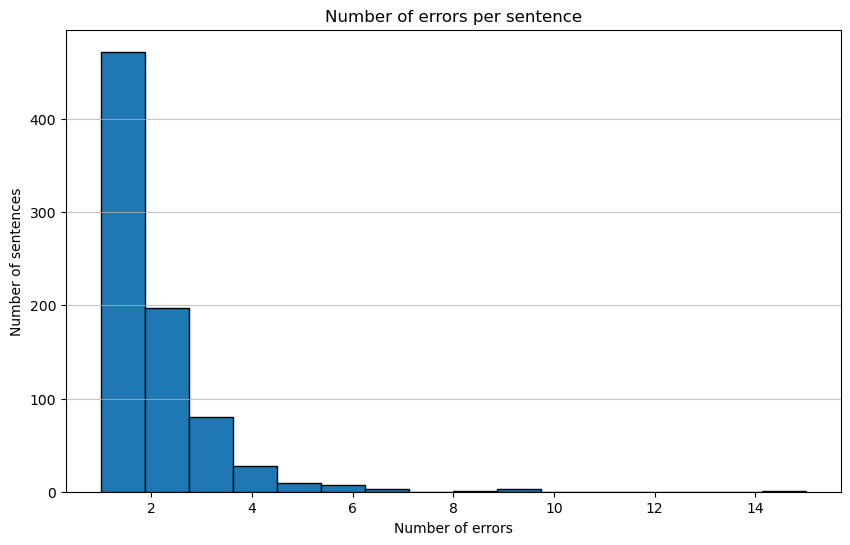

In [50]:
# Draw a histogram of the number of errors per sentence
plt.figure(figsize=(10, 6))
plt.hist([x[1] for x in hard_sentences], bins=16, edgecolor='black')
plt.title('Number of errors per sentence')
plt.xlabel('Number of errors')
plt.ylabel('Number of sentences')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [51]:
# Show prediction errors for sentences with more than 5 errors.
for s in hard_sentences:
    if s[1] > 5:
        print(" ".join(untag(s[0])))
        print('Number of errors:', s[1])
        for i in range(len(s[0])):
            if s[0][i][1] != s[2][i]:
                print(f'{s[0][i][0]:<20}  C: {s[0][i][1]:<12}  P: {s[2][i]:<12} **** Error')
            else:
                print(f'{s[0][i][0]:<23}  {s[0][i][1]:<12}')
        print(40*'=')


Stay with me now : John Paul STEVENS delivered the opinion of the Court with respect to Parts I through IV , VI through VI - D - iii , VI - D - v , and VII , in which KENNEDY , SOUTER , GINSBURG , and BREYER joined , and an opinion with respect to Parts V and VI - D - iv , in which SOUTER , GINSBURG , and BREYER joined .
Number of errors: 8
Stay                     VERB        
with                     ADP         
me                       PRON        
now                      ADV         
:                        PUNCT       
John                     PROPN       
Paul                     PROPN       
STEVENS               C: PROPN         P: NOUN         **** Error
delivered                VERB        
the                      DET         
opinion                  NOUN        
of                       ADP         
the                      DET         
Court                    NOUN        
with                     ADP         
respect                  NOUN        
to                   

## 

## Error Analysis

1. Identify tokens that are misclassified more than 10 times in the test set. Print the sentences where the errors are predicted (about 100 sentences).
2. Provide a possible reason why these errors are made by the tagger based on your understanding of the knowledge needed to correctly tag these tokens.
3. Based on this error analysis, invent five sentences that are badly tagged. Explain what is your method to create these hard examples.


In [52]:
# Identify tokens that are misclassified more than 10 times in the test set. 
error_counter = collections.Counter()
for sentence, _, pred in hard_sentences:
    for i, (word, tag) in enumerate(sentence):
        if tag != pred[i]:
            error_counter[word] += 1

misclassified_tokens = [word for word, count in error_counter.items() if count > 10]
print(f"Tokens misclassified more than 10 times: {misclassified_tokens}")

print("\nSentences with errors for these tokens:\n")
counter = 0
for sentence, _, pred in hard_sentences:
    if counter == 100:
        break
    for i, (word, tag) in enumerate(sentence):
        if word in misclassified_tokens and tag != pred[i]:
            print(f'{counter+1} - Sentence: {untag(sentence)}')
            print(f'Word: {word}, True tag: {tag}, Predicted tag: {pred[i]}')
            print(40*'=')
            counter += 1
            break

Tokens misclassified more than 10 times: ['out', 'on', 'as', 'to', '/', 'that', 'in', 'for', 'up', 'like', '01-Feb-02']

Sentences with errors for these tokens:

1 - Sentence: ['I', 'doubt', 'the', 'very', 'few', 'who', 'actually', 'read', 'my', 'blog', 'have', 'not', 'come', 'across', 'this', 'yet', ',', 'but', 'I', 'figured', 'I', 'would', 'put', 'it', 'out', 'there', 'anyways', '.']
Word: out, True tag: ADV, Predicted tag: ADP
2 - Sentence: ['John', 'Donovan', 'from', 'Argghhh!', 'has', 'put', 'out', 'a', 'excellent', 'slide', 'show', 'on', 'what', 'was', 'actually', 'found', 'and', 'fought', 'for', 'in', 'Fallujah', '.']
Word: on, True tag: SCONJ, Predicted tag: ADP
3 - Sentence: ['Angry', 'crowds', 'chanted', 'anti-American', 'slogans', 'in', 'the', 'western', 'city', 'of', 'Falluja', '(', 'pop.', '256,000', ')', 'as', 'the', 'security', 'police', 'killed', 'in', 'a', 'friendly', 'fire', 'incident', 'by', 'US', 'troops', 'were', 'buried', 'on', 'Saturday', '.']
Word: as, True tag:

### Possible reasons why these errors are made:
- **Ambiguity**: Some words can be used as different parts of speech depending on the context.
- **Out-of-vocabulary words**: The model may not have seen certain words during training, leading to incorrect predictions.
- **Lack of context**: The model may not have enough context to make an accurate prediction.

### Hard sentences:

1. The cat is out of the bag.
2. He is on the way to the store.
3. She is as smart as a whip.
4. The book is on the table.
5. He is going to the store for some milk.

##### Method to create hard examples:
I used ambigous words and words that could be out-of-vocabulary. I also used sentences with small context to make it harder for the model to predict the correct tag.

### 2.2 Error Analysis

In [54]:
# Compare the errors for the two taggers: Logistic Regression and the LLM-based with structured output on
# the hard sentences list of sentences that have 1 to 3 errors each (we ignore sentences that have many more
# errors as these cases are probably caused by a complete break-down of the expectations of the tagger).

filtered_hard_sentences = [s for s in hard_sentences if 1 <= s[1] <= 3]

In [53]:
import ud_pos_tagger_grok

Accuracy: 0.9326
f1-macro score: 0.8549
              precision    recall  f1-score   support

         ADJ     0.9102    0.8851    0.8974       870
         ADP     0.8816    0.9879    0.9318       995
         ADV     0.9475    0.8268    0.8830       589
         AUX     0.9396    0.9928    0.9655       690
       CCONJ     1.0000    0.9946    0.9973       367
         DET     0.9413    0.9935    0.9667       920
        INTJ     0.9000    0.8182    0.8571        44
        NOUN     0.9089    0.9469    0.9275      1959
         NUM     0.9231    0.9877    0.9543       243
        PART     0.9845    0.9938    0.9891       320
        PRON     0.9910    0.9281    0.9585       946
       PROPN     0.8884    0.8143    0.8498       948
       PUNCT     0.9874    0.9881    0.9878      1349
       SCONJ     0.7758    0.6337    0.6975       202
         SYM     0.5974    0.7541    0.6667        61
        VERB     0.9746    0.9335    0.9536      1233
           X     0.0455    0.0556    0.05

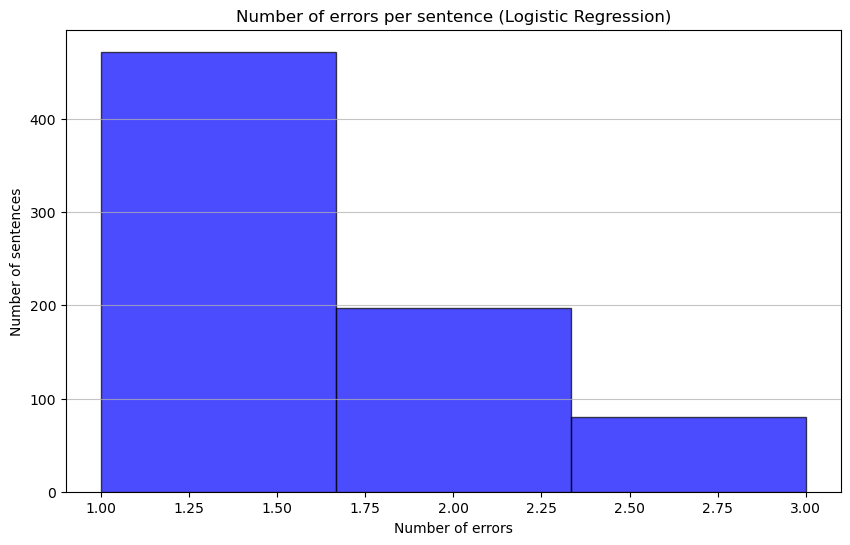

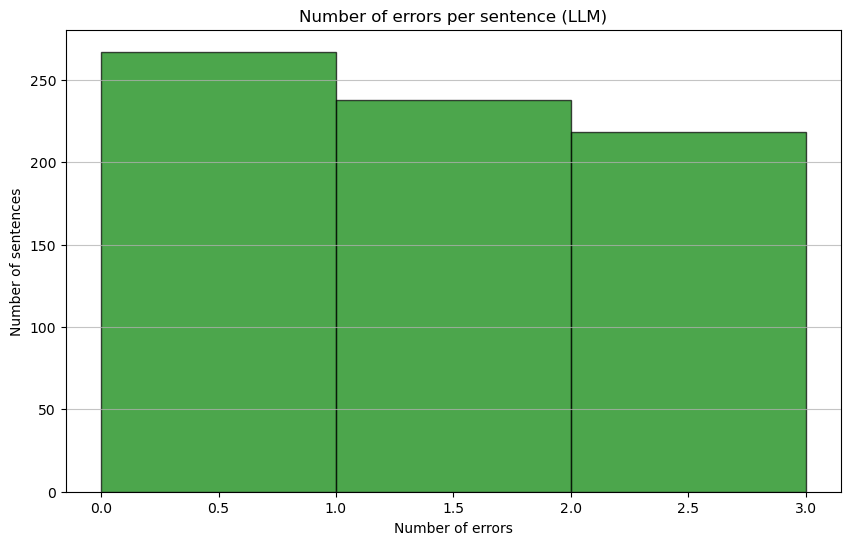

In [66]:
import os
from openai import OpenAI

# 1. Compute the same statistics reported for the Logistic Regression Tagger in the notebook for the LLM
# Tagger (token-level metric).
# 2. How many of the Logistic Regression Tagger errors are fixed by the LLM Tagger
# 3. How many errors are made by the LLM Tagger that were not made by the Logistic Regression Tagger

api_key = os.environ.get("GROK_API_KEY")
ud_pos_tagger_grok.client = OpenAI(
    api_key=api_key,
    base_url="https://api.x.ai/v1",
)

def evaluate_llm_tagger(test_sentences, batch_size=15):
    y_true = []
    y_pred = []
    fixed_errors = 0
    new_errors = 0
    llm_sentence_errors = []
    lr_sentence_errors = [s[1] for s in test_sentences]

    for i in range(0, len(test_sentences), batch_size):
        batch = test_sentences[i:i + batch_size]
        batch_tokens = [" ".join([token for token, _ in sentence]) for sentence, _, _ in batch]
        batch_tags = [[tag for _, tag in sentence] for sentence, _, _ in batch]
        batch_lr_preds = [pred for _, _, pred in batch]

        # Call the LLM-based tagger
        batch_text = "\n\n".join(batch_tokens)
        batch_predictions = ud_pos_tagger_grok.tag_sentences_ud(batch_text).sentences

        for j, sentence_result in enumerate(batch_predictions):
            predicted_tags = [token.pos_tag.value for token in sentence_result.tokens]

            if len(predicted_tags) == len(batch_tags[j]):
                y_true.extend(batch_tags[j])
                y_pred.extend(predicted_tags)

                # Compare predictions for error analysis
                sentence_errors = 0
                for k in range(len(predicted_tags)):
                    if batch_lr_preds[j][k] != batch_tags[j][k] and predicted_tags[k] == batch_tags[j][k]:
                        fixed_errors += 1
                    elif batch_lr_preds[j][k] == batch_tags[j][k] and predicted_tags[k] != batch_tags[j][k]:
                        new_errors += 1

                    if predicted_tags[k] != batch_tags[j][k]:
                        sentence_errors += 1

                llm_sentence_errors.append(sentence_errors)

    # convert each number >= 3 to 3 in llm_sentence_errors and lr_sentence_errors
    llm_sentence_errors = [min(3, x) for x in llm_sentence_errors]
    lr_sentence_errors = [min(3, x) for x in lr_sentence_errors]

    # Compute and print metrics
    print("Accuracy: {0:.4f}".format(accuracy_score(y_true, y_pred)))
    print('f1-macro score: {0:.4f}'.format(f1_score(y_true, y_pred, average='macro')))
    print(classification_report(y_true, y_pred, digits=4))

    # Print error analysis
    print(f"Fixed errors: {fixed_errors}")
    print(f"New errors: {new_errors}")

    # Plot histogram for Logistic Regression errors
    plt.figure(figsize=(10, 6))
    plt.hist(lr_sentence_errors, bins=3, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Number of errors per sentence (Logistic Regression)')
    plt.xlabel('Number of errors')
    plt.ylabel('Number of sentences')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Plot histogram for LLM errors
    plt.figure(figsize=(10, 6))
    plt.hist(llm_sentence_errors, bins=3, alpha=0.7, color='green', edgecolor='black')
    plt.title('Number of errors per sentence (LLM)')
    plt.xlabel('Number of errors')
    plt.ylabel('Number of sentences')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

evaluate_llm_tagger(filtered_hard_sentences)

5. Hypotheses and new sentences to make the LLM Tagger fail:

- LLM taggers often stumble on words that can play multiple roles, like “run” being either a noun or a verb, especially when there’s not much context to use. They also tend to have trouble with unusual sentence structures or ones that break typical grammar rules. Languages with lots of inflections, or words that show up rarely, can throw them off too. 
- Words like “that” or “to” are tricky because they can mean different things depending on the sentence. You’ll also see more mistakes when the model handles text from unfamiliar domains (like legal or poetic writing) or when languages get mixed together in the same sentence.

In [55]:
new_sentences = [
    "I saw her duck.",
    "Fruit flies like a banana.",
    "We painted the wall with cracks.",
    "I need to record the race record.",
]

for sentence in new_sentences:
    tagged_result = ud_pos_tagger_grok.tag_sentences_ud(sentence).sentences[0]
    print(f"Sentence: {sentence}")
    for token_pos in tagged_result.tokens:
        print(f"Word: {token_pos.token}, Predicted tag: {token_pos.pos_tag.value}")
    print(40*'=')

Sentence: I saw her duck.
Word: I, Predicted tag: PRON
Word: saw, Predicted tag: VERB
Word: her, Predicted tag: PRON
Word: duck, Predicted tag: NOUN
Sentence: Fruit flies like a banana.
Word: Fruit, Predicted tag: NOUN
Word: flies, Predicted tag: NOUN
Word: like, Predicted tag: VERB
Word: a, Predicted tag: DET
Word: banana, Predicted tag: NOUN
Sentence: We painted the wall with cracks.
Word: We, Predicted tag: PRON
Word: painted, Predicted tag: VERB
Word: the, Predicted tag: DET
Word: wall, Predicted tag: NOUN
Word: with, Predicted tag: ADP
Word: cracks, Predicted tag: NOUN
Sentence: I need to record the race record.
Word: I, Predicted tag: PRON
Word: need, Predicted tag: VERB
Word: to, Predicted tag: PART
Word: record, Predicted tag: VERB
Word: the, Predicted tag: DET
Word: race, Predicted tag: NOUN
Word: record, Predicted tag: NOUN
Word: ., Predicted tag: PUNCT


### 2.3 Error Explanation and Synthetic Data

In [67]:
# 1. Collect explanations generated by the LLM on a subset of errors.
def collect_error_explanations(errors):
    explanations = []
    for error in errors:
        prompt = f"""
        Given the following tagging error:
        Word: {error["word"]}
        Correct Tag: {error["correct_tag"]}
        Predicted Tag: {error["predicted_tag"]}
        Explain why this error might have occurred in the context of POS tagging.
        Also, categorize the error.
        """
        
        explanation, category = ud_pos_tagger_grok.get_tag_explanation(prompt)
        explanations.append({
            "word": error["word"],
            "correct_tag": error["correct_tag"],
            "predicted_tag": error["predicted_tag"],
            "explanation": explanation,
            "category": category,

        })
    return explanations

# Collect errors
errors = []
for sentence, _, pred in hard_sentences:
    for i, (word, tag) in enumerate(sentence):
        if tag != pred[i]:
            errors.append({
                "word": word,
                "correct_tag": tag,
                "predicted_tag": pred[i],
            })

explanations = collect_error_explanations(errors[:100])
for explanation in explanations:
    print(f"Word: {explanation["word"]}")
    print(f"Correct Tag: {explanation["correct_tag"]}")
    print(f"Predicted Tag: {explanation["predicted_tag"]}")
    print(f"Explanation: {explanation["explanation"]}")
    print(f"Category: {explanation["category"]}")
    print(40*'=')

Word: wares
Correct Tag: NOUN
Predicted Tag: VERB
Explanation: The error in tagging 'wares' as a VERB instead of a NOUN likely occurred due to the ambiguity in the word's form and the limitations of the POS tagging model. 'Wares' is typically a noun referring to goods or merchandise, but it resembles verb forms due to the '-s' ending, which is often associated with third-person singular verbs in English (e.g., 'cares', 'dares'). If the tagging model relies heavily on morphological cues or has insufficient training data to recognize 'wares' as a noun, it might misclassify it as a verb. Additionally, if the surrounding context in the sentence does not provide clear syntactic or semantic clues (e.g., no determiners like 'the' or 'these' before 'wares'), the model may default to a more frequent pattern, such as assuming an '-s' ending indicates a verb. This error could also stem from the model's training data, where similar words or patterns were more commonly tagged as verbs.
Category: Mo

In [68]:
# 2. Collect the list of error categories provided by the explanation of errors.

categories = set()

for explanation in explanations:
    if "category" in explanation:
        categories.add(explanation["category"])

categories = list(categories)
print("Error categories:")
for category in categories:
    print(category)

Error categories:
Contextual or Training Data Error
Morphological and Contextual Ambiguity
Ambiguity and Contextual Misinterpretation
Lexical Ambiguity Error
Ambiguity and Context Insensitivity
Ambiguity in Contextual Usage
Morphological Confusion
Contextual Ambiguity and Training Data Bias
Confusion due to word ambiguity and context dependency
Ambiguity in Context or Training Data
Ambiguity due to Capitalization and Context
Ambiguity and Training Data Limitation
Ambiguity Error
Ambiguity and Capitalization Error
Ambiguity/Training Data Bias
Semantic/Contextual Ambiguity
Contextual and Training Data Error
Ambiguity and Training Data Bias
Capitalization-based Error
Lexical and Contextual Ambiguity
Morphological Ambiguity
Contextual Ambiguity and Frequency Bias
Contextual Ambiguity
Ambiguity and Frequency Bias


# 3. Dealing with Segmentation 

1. Test the performance of the LLM tagger on the original sentences. Do you need to update the
evaluation metrics for this new setting? Collect sentences that fail with original sentences and
succeeded with the tokenized version.

In [69]:
from nltk.metrics.distance import edit_distance

# Tokens cost function
def token_similarity(token1, token2):
    return 1 - ((edit_distance(token1, token2) / max(len(token1), len(token2))) if token1 and token2 else 1)
    

# make an alignment function for tag sentences that does not have the same number of tokens because of 
# the tokenization process. This function will align the original sentences with the test sentences
def align_sentence(gold_tokens, pred_tokens, gold_tags, pred_tags):
    aligned_pairs = []
    used_pred_indices = set()

    # For each gold token, find the best matching predicted token
    for i, gold_token in enumerate(gold_tokens):
        best_index = -1
        best_score = -1
        for j, pred_token in enumerate(pred_tokens):
            if j in used_pred_indices:
                continue
            score = token_similarity(gold_token, pred_token)
            if score > best_score:
                best_score = score
                best_index = j
        if best_index != -1:
            aligned_pairs.append((gold_tags[i], pred_tags[best_index]))
            used_pred_indices.add(best_index)

    return aligned_pairs

In [71]:
# Evaluate the LLM-based tagger on the original sentences
def evaluate_llm_tagger_on_original_sentences(original_sentences, test_sentences, batch_size = 15):
    mismatched_sentences = []
    y_true = []
    y_pred = []

    for i in range(0, len(original_sentences), batch_size):
        batch_original = original_sentences[i:i + batch_size]
        batch_tokenized = test_sentences[i:i + batch_size]

        # Call the LLM-based tagger for original sentences
        batch_original_predictions = ud_pos_tagger_grok.tag_sentences_ud("\n\n".join(batch_original)).sentences

        # Call the LLM-based tagger for tokenized sentences
        batch_tokenized_text = [" ".join(untag(sentence)) for sentence in batch_tokenized]
        batch_tokenized_predictions = ud_pos_tagger_grok.tag_sentences_ud("\n\n".join(batch_tokenized_text)).sentences

        for j, (tokenized_sentence, original_sentence) in enumerate(zip(batch_tokenized_predictions, batch_original_predictions)):
            original_tokens = [token.token for token in original_sentence.tokens]
            original_tags = [token.pos_tag.value for token in original_sentence.tokens]
            tokenized_tags = [token.pos_tag.value for token in tokenized_sentence.tokens]
            gold_tokens = [word for word, _ in test_sentences[i + j]]
            gold_tags = [tag for _, tag in test_sentences[i + j]]
            
            # Use the alignment function to align the tokens and tags
            if len(gold_tags) != len(original_tags):
                aligned_pairs = align_sentence(gold_tokens, original_tokens, gold_tags, original_tags)
                if aligned_pairs:
                    y_true.extend([pair[0] for pair in aligned_pairs])
                    y_pred.extend([pair[1] for pair in aligned_pairs])

                # Check for mismatches
                if [pair[1] for pair in aligned_pairs] != gold_tags and tokenized_tags == gold_tags:
                    mismatched_sentences.append((original_sentence, [pair[1] for pair in aligned_pairs], gold_tags))
                continue

            # Check for mismatches
            if original_tags != gold_tags and tokenized_tags == gold_tags:
                mismatched_sentences.append((original_sentence, original_tags, gold_tags))

            y_true.extend(gold_tags)
            y_pred.extend(original_tags)

    # Compute metrics
    print("Accuracy: {0:.4f}".format(accuracy_score(y_true, y_pred)))
    print('f1-macro score: {0:.4f}'.format(f1_score(y_true, y_pred, average='macro')))
    print(classification_report(y_true, y_pred, digits=4))

    return mismatched_sentences

original = test_original
sentences = test_sentences
mismatched_sentences = evaluate_llm_tagger_on_original_sentences(original, sentences)
for sentence in mismatched_sentences:
    print(" ".join([token.token for token in sentence[0].tokens]))
    print(f"Predicted Tags: {sentence[1]}")
    print(f"Gold Tags: {sentence[2]}")
    print(40*'=')

Accuracy: 0.8681
f1-macro score: 0.7918
              precision    recall  f1-score   support

         ADJ     0.8579    0.8507    0.8543      1675
         ADP     0.8399    0.9132    0.8750      1901
         ADV     0.8800    0.8199    0.8489      1127
         AUX     0.8543    0.8863    0.8700      1469
       CCONJ     0.9312    0.9217    0.9264       690
         DET     0.8855    0.9316    0.9079      1784
        INTJ     0.7226    0.8684    0.7888       114
        NOUN     0.8456    0.8885    0.8665      3802
         NUM     0.8671    0.9002    0.8833       471
        PART     0.9038    0.8218    0.8608       606
        PRON     0.9240    0.8824    0.9027      2066
       PROPN     0.8465    0.7454    0.7927      1901
       PUNCT     0.9057    0.9078    0.9068      2657
       SCONJ     0.7287    0.6346    0.6784       364
         SYM     0.4583    0.5914    0.5164        93
        VERB     0.8942    0.8600    0.8768      2436
           X     0.0741    0.1818    0.10

2.Prepare an LLM segmenter model: given an original sentence, it must return a tokenized list of tokens
according to the CoNLL segmentation guidelines in a JSON format. The tokenization and word
segmentation guidelines used in English for the Universal Dependency annotations are given in
https://universaldependencies.org/en/index.html. Define evaluation metrics for this task and report
the performance on the set of sentences where tagging failed in the evaluation above.

1. Use a few-shots strategy for this task: give a few examples (up to 3) of input/output pairs
    (original sentence, segmented sentence) and then ask the model to segment based on these
    examples. In this strategy, you add the instruction in the "system" part of the invocation, and
    the examples in the "user" part.

In [73]:
def segment_sentence(instruction, examples, sentence):
    prompt = f"{instruction}\n\n"
    for example in examples:
        prompt += f"Original: {example['original']}\nSegmented: {example['segmented']}\n\n"
    prompt += f"Original: {sentence}\nSegmented: "

    # Call the API
    response = ud_pos_tagger_grok.tokenize_sentence(instruction, prompt)
    return response

def evaluate_segmentation(instruction, examples, sentences, gold_segmentations):
    correct = 0
    total = 0

    for sentence, gold_segmentation in zip(sentences, gold_segmentations):
        segmented_sentence = segment_sentence(instruction, examples, sentence)
        
        total += len(gold_segmentation)

        for s, g in zip(segmented_sentence, gold_segmentation):
            if s == g:
                correct += 1

    score = correct / total if total > 0 else 0
    return score

# Usage
instruction = "Segment the following sentence into tokens according to CoNLL guidelines and use the following examples as a reference."
examples = [
    {"original": "I saw her duck.", "segmented": ["I", "saw", "her", "duck", "."]},
    {"original": "Fruit flies like a banana.", "segmented": ["Fruit", "flies", "like", "a", "banana", "."]},
    {"original": "He can't go.", "segmented": ["He", "ca", "n't", "go", "."]},
]
# The sentences are from mismatched_sentences
sentences = [" ".join([token.token for token in sentence[0].tokens]) for sentence in mismatched_sentences]
gold_segmentations = [[token.token for token in sentence[0].tokens] for sentence in mismatched_sentences]
score = evaluate_segmentation(instruction, examples, sentences, gold_segmentations)
print(f"Segmentation score: {score:.4f}")

Segmentation score: 0.7823
